# Titanic

In this kernel, I'm working on the Titanic kaggle challenge: https://www.kaggle.com/c/titanic

## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

## Exploratory Data Analysis

### Read the data

In [2]:
# read all the data in the train file
data = pd.read_csv('data/train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The data consists of a table of 11 columns:
* PassengerId: obvious
* Survived: 0 -> no, 1 -> yes; the target variable
* Pclass: 1 -> upper, 2 -> middle, 3 -> lower
* Name: passenger name, probably irrelevant
* Sex: male, female
* Age: obvious
* SibSp: # of siblings or spouses aboard
* Parch: # of parent or children aboard
* Ticket: ticket number (I doubt it will be relevant)
* Fare: depends on the class I guess
* Cabin: cabin number (I don't think it will be relvant. All the information it may bring is I think -a priori- carried by Pclass and eventually Fare)
* Embarked: port of embarkation; C = Cherbourg, Q = Queenstown, S = Southampton (I would say it's irrelevant, we'll see if it is or not)

### Clean the data

In [4]:
data.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

There are 891 rows. We see that the columns 'Age', 'Cabin' and 'Embarked' have missing values; we need to fill them. We'll also transform the categorical data into numerical (ordinal) data because it's easier to work with. Finally, we'll drop the 'PassengerId' and 'Name' columns because they don't provide any information necessary for the classification.

In [5]:
def preprocess(df):
    # fill in the missing values
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Cabin'].fillna('UNK', inplace=True)
    df['Embarked'].fillna('UNK', inplace=True)
    
    # categorical data encoding
    enc = LabelEncoder()
    columns_to_encode = ['Sex', 'Ticket', 'Fare', 'Cabin', 'Embarked']
    for column in columns_to_encode:
        df[column] = enc.fit_transform(df[column])
    
    # drop the 'PassengerId' and 'Name' columns
    df.drop('PassengerId', axis=1, inplace=True)
    df.drop('Name', axis=1, inplace=True)

In [6]:
preprocess(data)
print(data.count())
data.head()

Survived    891
Pclass      891
Sex         891
Age         891
SibSp       891
Parch       891
Ticket      891
Fare        891
Cabin       891
Embarked    891
dtype: int64


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,523,18,147,2
1,1,1,0,38.0,1,0,596,207,81,0
2,1,3,0,26.0,0,0,669,41,147,2
3,1,1,0,35.0,1,0,49,189,55,2
4,0,3,1,35.0,0,0,472,43,147,2


Now, all the columns have 891 values, and we see numbers, numbers everywhere, that's what we want.

### Explore the data

In [7]:
data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.361582,0.523008,0.381594,338.528620,105.355780,130.744108,1.538721
std,0.486592,0.836071,0.477990,13.019697,1.102743,0.806057,200.850657,70.082521,36.024237,0.794231
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,158.500000,40.500000,147.000000,1.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,337.000000,94.000000,147.000000,2.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,519.500000,157.000000,147.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,680.000000,247.000000,147.000000,3.000000


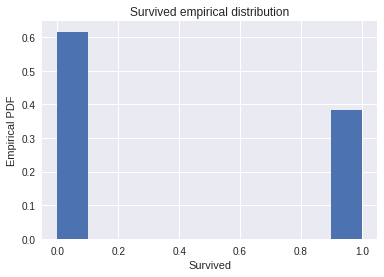

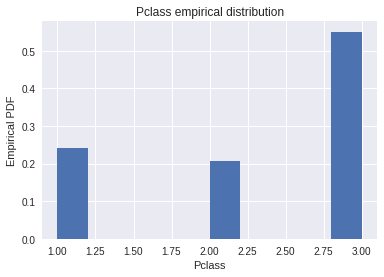

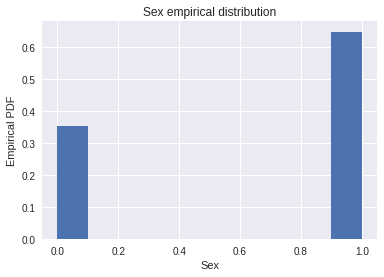

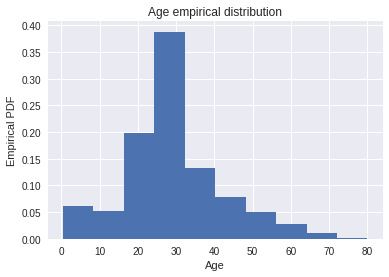

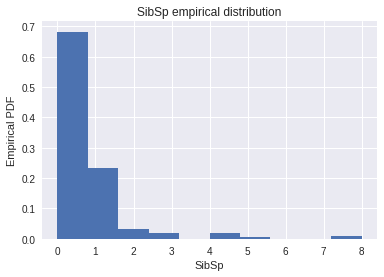

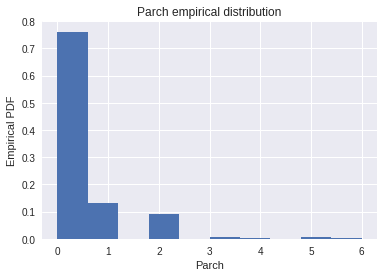

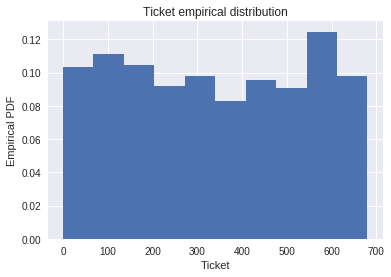

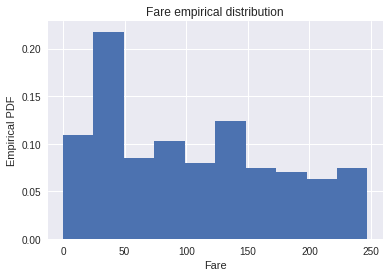

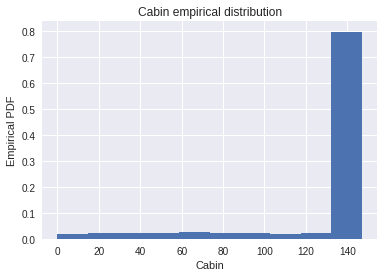

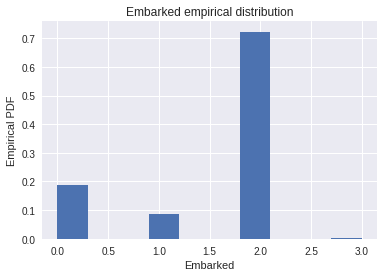

In [8]:
# empirical distributions of the features and the target
for column in data.columns:
    plt.hist(data[column], weights=np.ones(len(data)) / len(data))
    plt.title('{0} empirical distribution'.format(column))
    plt.xlabel('{0}'.format(column))
    plt.ylabel('Empirical PDF')
    plt.show()

We can make the following remarks:
* Around 60% of the passengers survived (and around 40% died). The classes are relatively well balanced, so it makes sense to use the accuracy as the evaluation metric.
* The lower class (Pclass = 3) makes up more than half of the passenger. The upper and middle class are somewhat similarly represented.
* Females make up around 65% of the passengers, and males around 35%.
* The age is distributed following what seems to be a gaussian distribution, with it's mean around 30. We must keep in mind that a significant number of the age values were missing (around 20%) and were replaced by the remaining values's median.
* The SibSp column follows a Poisson distribution, with the value 0 being highly represented, the value 1 a little bit, and the other ones from there very rarely.
* The Parch column also follows a Poisson distribution.
* Tickets follow an almost uniform distribution.
* Fares also follow a uniform-like distribution, with the exception of some values which are more highly represented.
* Cabin is a column which has a lot of missing values (around 77%). Those missing values corresond to the pick in the histogram. The other values seem to be distributed uniformly, although we have to rescale and have more data in order to asses that more confidently. In any case, this information is probably useless due to the number of missing values.
* Embarked has very few missing values. There are 3 ports of embarkation, they represent around 10%, 20% and 70% of the passengers respectively.

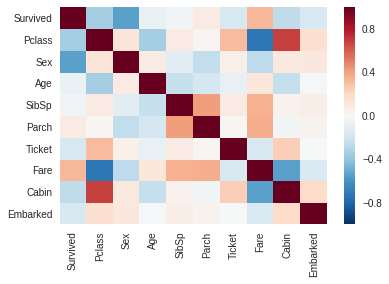

In [9]:
# correlation
corr = data.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

From the correlation matrix, we see that the 'Survived' variable is highly correlated with 'Sex', 'Pclass', and surprisingly 'Fare'. The correlation with 'Age' is not as high as I expected it, maybe because of the missing values that were replaced by the median.

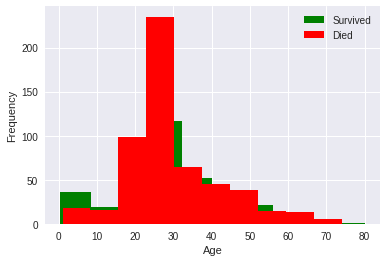

In [10]:
plt.hist(data['Age'].loc[data['Survived'] == 1], color='g', label='Survived')
plt.hist(data['Age'].loc[data['Survived'] == 0], color='r', label='Died')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

The 2 distribution almost overlap. I guess age really doesn't play a significant role, although one might notice that for ages < 10, the survival rate is significantly higher; but this category is rare relative to the general population so it won't provide much discriminative information.

## Baseline: random forest

We'll use a random forest classifier with the scikit-learn default hyperparameters as our baseline.

In [11]:
X = data.drop('Survived', axis=1).values
y = data['Survived'].values
clf = RandomForestClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8044692737430168

The baseline is about 80%, which is very high for a baseline. But let's not forget that the dataset is relatively small, and the test set used here contains less than 200 entries. Results may vary if I use a larger dataset.

Now I'll work on improving that.

## Classification

We'll first prepare the data for classification (mostly by doing one-hot encoding). Then, we'll test a bunch of classical classification algorithm using (mostly) the default hyperparameters of scikit-learn. After that, we'll do some hyperparameter tuning using cross-validation on the best performing basic classifiers.

### Feature extraction

Age, SibSp and Parch will remain as they are, their quantitative nature corresponds to what they mean in reality.

One-hot encoding will be applied to Pclass, Sex and Embarked.

Ticket, Fare and Cabin represent categorical data with numerous possible values. We're going to keep only the most common values.

In [12]:
encoders = dict()

In [13]:
def feature_extraction(df, test=False):
    # Age, SibSp and Parch
    X = np.concatenate((df['Age'].values.reshape(-1, 1),
                       df['SibSp'].values.reshape(-1, 1),
                       df['Parch'].values.reshape(-1, 1)),
                       axis=1)
    
    # one-hot encoding of Pclass, Sex and Embarked
    for column in ['Pclass', 'Sex', 'Embarked']:
        if test:
            values = np.array(encoders[column].transform(df[column].values.reshape(-1, 1)).todense())
        else:
            encoders[column] = OneHotEncoder(handle_unknown='ignore')
            values = np.array(encoders[column].fit_transform(df[column].values.reshape(-1, 1)).todense())
        X = np.concatenate((X, values), axis=1)
    
    # For columns Ticket, Fare and Cabin, we only keep the most common values
    num_values_to_keep = {
        'Ticket': 8,
        'Fare': 15,
        'Cabin': 4
    }
    for column in ['Ticket', 'Fare', 'Cabin']:
        if not test:
            counts = Counter(df[column])
            most_common_counts = counts.most_common(num_values_to_keep[column])
            values_to_keep = list(map(lambda x: x[0], most_common_counts))
            encoders[column] = OneHotEncoder(handle_unknown='ignore')
            encoders[column].fit(np.array(values_to_keep).reshape(-1, 1))
        values = np.array(encoders[column].transform(df[column].values.reshape(-1, 1)).todense())
        X = np.concatenate((X, values), axis=1)
    
    return X

In [14]:
X = feature_extraction(data)
y = data['Survived'].values

### Basic classifiers

In [15]:
clfs = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear'),
    'svm2': SVC(kernel='rbf'),
    'svm3': SVC(kernel='sigmoid'),
    'mlp1': MLPClassifier(),
    'mlp2': MLPClassifier(hidden_layer_sizes=[100, 100]),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression()
}

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
accuracies = dict()
for clf_name in clfs:
    clf = clfs[clf_name]
    clf.fit(X_train, y_train)
    accuracies[clf_name] = clf.score(X_valid, y_valid)

In [33]:
accuracies

{'ada': 0.84916201117318435,
 'dtc': 0.78212290502793291,
 'gbc': 0.83798882681564246,
 'gnb': 0.4972067039106145,
 'lr': 0.86033519553072624,
 'mlp1': 0.84916201117318435,
 'mlp2': 0.82681564245810057,
 'mnb': 0.83240223463687146,
 'rfc': 0.82122905027932958,
 'svm1': 0.81564245810055869,
 'svm2': 0.82681564245810057,
 'svm3': 0.53072625698324027}

Good results seem to be given by the SVM with RBF kernel and by the 2 layers feedforward neural network. I'll perform hyperparameter optimization on these two models next. Other models also give good results (AdaBoost, Gradient Boosting, Multinomial Naive Bayes, ...) but for now, I'll just work on the SVM and the neural network.

### SVM hyperparameters optimization

In [34]:
# the kernel is RBF
parameters = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.01, 0.1]
}

In [35]:
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring='accuracy', return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100], 'gamma': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [36]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.033475,0.013957,0.635241,0.638047,1,0.001,"{'C': 1, 'gamma': 0.001}",9,0.626263,0.641414,0.636364,0.638047,0.643098,0.634680,0.000736,0.001252,0.006919,0.002749
1,0.031749,0.012482,0.797980,0.810887,1,0.01,"{'C': 1, 'gamma': 0.01}",5,0.801347,0.821549,0.801347,0.803030,0.791246,0.808081,0.000549,0.000211,0.004762,0.007816
2,0.037128,0.012155,0.811448,0.860269,1,0.1,"{'C': 1, 'gamma': 0.1}",3,0.781145,0.882155,0.828283,0.850168,0.824916,0.848485,0.001516,0.000275,0.021472,0.015491
3,0.030576,0.011172,0.810325,0.814254,10,0.001,"{'C': 10, 'gamma': 0.001}",4,0.811448,0.819865,0.818182,0.811448,0.801347,0.811448,0.001287,0.000277,0.006919,0.003968
4,0.031744,0.009088,0.821549,0.831089,10,0.01,"{'C': 10, 'gamma': 0.01}",1,0.814815,0.835017,0.831650,0.828283,0.818182,0.829966,0.002840,0.000229,0.007274,0.002861
5,0.040955,0.010127,0.776655,0.936027,10,0.1,"{'C': 10, 'gamma': 0.1}",7,0.764310,0.949495,0.787879,0.932660,0.777778,0.925926,0.001669,0.000481,0.009655,0.009912
6,0.033775,0.008432,0.817059,0.824916,100,0.001,"{'C': 100, 'gamma': 0.001}",2,0.814815,0.833333,0.824916,0.823232,0.811448,0.818182,0.003052,0.000161,0.005723,0.006299
7,0.052345,0.008060,0.794613,0.884400,100,0.01,"{'C': 100, 'gamma': 0.01}",6,0.750842,0.900673,0.818182,0.872054,0.814815,0.880471,0.007843,0.000319,0.030981,0.012010
8,0.055551,0.009839,0.762065,0.969136,100,0.1,"{'C': 100, 'gamma': 0.1}",8,0.754209,0.978114,0.764310,0.966330,0.767677,0.962963,0.006651,0.000301,0.005723,0.006496


The best score (for the test) is $0.82$ and it is obtained for $C = 10$ and $\gamma = 0.01$. This is a little bit disappointing knowing that we got the same score in our baseline.

### Neural network hyperparameters optimization

In the first time, we'll tune the neural network's number of layers and number of units per layer. After that, we'll optimize other hyperparameters.

In [37]:
parameters = {
    'hidden_layer_sizes': [
        [50,],
        [100,],
        [200,],
        [50, 50],
        [50, 100],
        [100, 50],
        [100, 100],
        [200, 200],
        [100, 100, 100]
    ]
}

In [40]:
mlp = MLPClassifier()
clf = GridSearchCV(mlp, parameters, scoring='accuracy', return_train_score=True)
clf.fit(X, y)

/home/ghiles/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'hidden_layer_sizes': [[50], [100], [200], [50, 50], [50, 100], [100, 50], [100, 100], [200, 200], [100, 100, 100]]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [41]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_hidden_layer_sizes,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.301975,0.001292,0.700337,0.728956,[50],{'hidden_layer_sizes': [50]},9,0.818182,0.865320,0.616162,0.616162,0.666667,0.705387,0.344140,0.000218,0.085842,0.103075
1,0.673058,0.001334,0.821549,0.854097,[100],{'hidden_layer_sizes': [100]},1,0.811448,0.872054,0.821549,0.845118,0.831650,0.845118,0.115879,0.000377,0.008247,0.012698
2,0.775510,0.001565,0.753086,0.780022,[200],{'hidden_layer_sizes': [200]},8,0.818182,0.868687,0.821549,0.853535,0.619529,0.617845,0.510256,0.000037,0.094450,0.114843
3,0.487056,0.001599,0.756453,0.768238,"[50, 50]","{'hidden_layer_sizes': [50, 50]}",6,0.622896,0.627946,0.814815,0.826599,0.831650,0.850168,0.341058,0.000420,0.094689,0.099667
4,0.537638,0.001363,0.755331,0.775533,"[50, 100]","{'hidden_layer_sizes': [50, 100]}",7,0.804714,0.860269,0.821549,0.829966,0.639731,0.636364,0.377539,0.000051,0.082030,0.099182
5,0.416390,0.001489,0.810325,0.835578,"[100, 50]","{'hidden_layer_sizes': [100, 50]}",5,0.804714,0.848485,0.791246,0.816498,0.835017,0.841751,0.054002,0.000147,0.018305,0.013769
6,0.678461,0.001893,0.812570,0.837262,"[100, 100]","{'hidden_layer_sizes': [100, 100]}",4,0.784512,0.833333,0.814815,0.824916,0.838384,0.853535,0.256673,0.000245,0.022050,0.012010
7,1.277355,0.005312,0.815937,0.846240,"[200, 200]","{'hidden_layer_sizes': [200, 200]}",3,0.784512,0.853535,0.828283,0.831650,0.835017,0.853535,0.477167,0.000829,0.022391,0.010317
8,0.581189,0.002728,0.821549,0.838384,"[100, 100, 100]","{'hidden_layer_sizes': [100, 100, 100]}",1,0.808081,0.848485,0.831650,0.836700,0.824916,0.829966,0.067394,0.000327,0.009912,0.007653


3 hidden layers with 100 units each seem to be the best architecture, giving a test accuracy of 0.82 and not overfitting very much (small difference between train score and test score). We'll keep this architecture and optimize other hyperparameters.

In [42]:
parameters = {
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam']
}

In [43]:
mlp = MLPClassifier(hidden_layer_sizes=[100, 100, 100])
clf = GridSearchCV(mlp, parameters, scoring='accuracy', return_train_score=True)
clf.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[100, 100, 100], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'activation': ['logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [44]:
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_activation,param_solver,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,5.198135,0.006849,0.815937,0.851852,logistic,lbfgs,"{'activation': 'logistic', 'solver': 'lbfgs'}",3,0.801347,0.856902,0.831650,0.855219,0.814815,0.843434,0.307985,0.000965,0.012397,0.005992
1,0.275103,0.005554,0.616162,0.616162,logistic,sgd,"{'activation': 'logistic', 'solver': 'sgd'}",8,0.616162,0.616162,0.616162,0.616162,0.616162,0.616162,0.027726,0.000711,0.000000,0.000000
2,0.165753,0.007802,0.616162,0.616162,logistic,adam,"{'activation': 'logistic', 'solver': 'adam'}",8,0.616162,0.616162,0.616162,0.616162,0.616162,0.616162,0.019561,0.000335,0.000000,0.000000
3,5.416595,0.006964,0.810325,0.856902,tanh,lbfgs,"{'activation': 'tanh', 'solver': 'lbfgs'}",5,0.801347,0.880471,0.821549,0.840067,0.808081,0.850168,0.107609,0.000488,0.008399,0.017168
4,1.136373,0.006667,0.676768,0.687991,tanh,sgd,"{'activation': 'tanh', 'solver': 'sgd'}",7,0.626263,0.627946,0.616162,0.624579,0.787879,0.811448,1.367824,0.000698,0.078676,0.087308
5,0.853242,0.007210,0.819304,0.838384,tanh,adam,"{'activation': 'tanh', 'solver': 'adam'}",1,0.814815,0.860269,0.821549,0.823232,0.821549,0.831650,0.212195,0.000862,0.003174,0.015852
6,4.212468,0.003659,0.819304,0.832211,relu,lbfgs,"{'activation': 'relu', 'solver': 'lbfgs'}",1,0.824916,0.819865,0.811448,0.833333,0.821549,0.843434,0.293463,0.000454,0.005723,0.009655
7,1.893524,0.002494,0.772166,0.797980,relu,sgd,"{'activation': 'relu', 'solver': 'sgd'}",6,0.781145,0.794613,0.754209,0.774411,0.781145,0.824916,0.077462,0.000171,0.012698,0.020756
8,0.686901,0.002791,0.812570,0.841190,relu,adam,"{'activation': 'relu', 'solver': 'adam'}",4,0.774411,0.838384,0.828283,0.838384,0.835017,0.846801,0.231025,0.000536,0.027122,0.003968


The test accuracy is still around 0.82, the best parameters being 'tanh' for the activation function and 'adam' for the solver, which are the default parameters.

Since there is no significant improvement over the baseline after all this feature encoding and hyperparameter tuning, I will just use the data without any encoding (as I did for the baseline) and see what happens.

### Without data encoding

In [45]:
X = data.drop('Survived', axis=1).values
y = data['Survived'].values

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
accuracies = dict()
for clf_name in clfs:
    clf = clfs[clf_name]
    clf.fit(X_train, y_train)
    accuracies[clf_name] = clf.score(X_valid, y_valid)

In [47]:
accuracies

{'ada': 0.7988826815642458,
 'dtc': 0.79329608938547491,
 'gbc': 0.81564245810055869,
 'gnb': 0.72067039106145248,
 'lr': 0.77653631284916202,
 'mlp1': 0.65363128491620115,
 'mlp2': 0.65363128491620115,
 'mnb': 0.58100558659217882,
 'rfc': 0.82681564245810057,
 'svm1': 0.77653631284916202,
 'svm2': 0.6033519553072626,
 'svm3': 0.5977653631284916}

The random forest classifier seems to perform best, so I'll do some hyperparameter optimization on it.

In [48]:
parameters = {
    'n_estimators': [10, 50, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'bootstrap': [True, False]
}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, scoring='accuracy', return_train_score=True)
clf.fit(X, y)
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_criterion,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.040844,0.003511,0.823793,0.982043,True,gini,None,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",17,0.797980,0.983165,0.841751,0.981481,0.831650,0.981481,0.007544,0.001515,0.018713,0.000794
1,0.164406,0.011589,0.818182,0.997194,True,gini,None,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",25,0.784512,0.996633,0.838384,0.996633,0.831650,0.998316,0.013489,0.001313,0.023967,0.000794
2,0.319486,0.018740,0.821549,0.998316,True,gini,None,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",23,0.791246,0.998316,0.818182,0.996633,0.855219,1.000000,0.044562,0.000114,0.026225,0.001375
3,0.476863,0.029563,0.822671,0.998316,True,gini,None,150,"{'bootstrap': True, 'criterion': 'gini', 'max_...",20,0.791246,0.998316,0.828283,0.996633,0.848485,1.000000,0.051385,0.002466,0.023702,0.001375
4,0.606382,0.039708,0.828283,0.998316,True,gini,None,200,"{'bootstrap': True, 'criterion': 'gini', 'max_...",9,0.808081,0.998316,0.841751,0.996633,0.835017,1.000000,0.006615,0.004371,0.014547,0.001375
5,0.036963,0.003004,0.800224,0.874860,True,gini,5,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",55,0.757576,0.890572,0.818182,0.882155,0.824916,0.851852,0.000870,0.000482,0.030282,0.016628
6,0.134726,0.008466,0.801347,0.875982,True,gini,5,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",53,0.754209,0.893939,0.828283,0.868687,0.821549,0.865320,0.009748,0.000082,0.033445,0.012772
7,0.255768,0.016443,0.804714,0.882716,True,gini,5,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",42,0.764310,0.885522,0.831650,0.888889,0.818182,0.873737,0.000710,0.000042,0.029094,0.006496
8,0.382978,0.024344,0.806958,0.886644,True,gini,5,150,"{'bootstrap': True, 'criterion': 'gini', 'max_...",41,0.754209,0.892256,0.841751,0.883838,0.824916,0.883838,0.001965,0.000095,0.037928,0.003968
9,0.511307,0.032052,0.810325,0.884961,True,gini,5,200,"{'bootstrap': True, 'criterion': 'gini', 'max_...",33,0.767677,0.895623,0.845118,0.880471,0.818182,0.878788,0.000636,0.000116,0.032100,0.007571


The best accuracy is again around 0.82. Now, I will perform another hyperparameter optimization on random forests but by using data encoding.

### Random forest hyperparameter optimization with data encoding

In [49]:
X = feature_extraction(data)
y = data['Survived'].values

In [50]:
parameters = {
    'n_estimators': [10, 50, 100, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'bootstrap': [True, False]
}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, scoring='accuracy', return_train_score=True)
clf.fit(X, y)
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_bootstrap,param_criterion,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.031458,0.003201,0.789001,0.952862,True,gini,None,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",46,0.764310,0.964646,0.801347,0.954545,0.801347,0.939394,0.003374,0.000814,0.017459,0.010378
1,0.142488,0.010374,0.786756,0.973625,True,gini,None,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",47,0.767677,0.979798,0.781145,0.974747,0.811448,0.966330,0.002909,0.000186,0.018305,0.005555
2,0.302570,0.021939,0.791246,0.974747,True,gini,None,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",44,0.767677,0.981481,0.797980,0.974747,0.808081,0.968013,0.007154,0.001970,0.017168,0.005498
3,0.484753,0.031698,0.793490,0.974747,True,gini,None,150,"{'bootstrap': True, 'criterion': 'gini', 'max_...",42,0.774411,0.981481,0.801347,0.974747,0.804714,0.968013,0.050861,0.004234,0.013561,0.005498
4,0.609070,0.039123,0.785634,0.974747,True,gini,None,200,"{'bootstrap': True, 'criterion': 'gini', 'max_...",49,0.760943,0.981481,0.784512,0.974747,0.811448,0.968013,0.032632,0.001227,0.020634,0.005498
5,0.028930,0.002598,0.808081,0.840067,True,gini,5,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",26,0.791246,0.856902,0.831650,0.823232,0.801347,0.840067,0.002022,0.000513,0.017168,0.013746
6,0.135594,0.009979,0.819304,0.840067,True,gini,5,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",4,0.811448,0.855219,0.831650,0.824916,0.814815,0.840067,0.001737,0.001238,0.008837,0.012371
7,0.276443,0.017412,0.815937,0.850168,True,gini,5,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",10,0.794613,0.863636,0.835017,0.838384,0.818182,0.848485,0.012653,0.000059,0.016571,0.010378
8,0.420002,0.029824,0.808081,0.852413,True,gini,5,150,"{'bootstrap': True, 'criterion': 'gini', 'max_...",26,0.791246,0.861953,0.818182,0.848485,0.814815,0.846801,0.026278,0.006045,0.011983,0.006781
9,0.536764,0.033934,0.818182,0.848485,True,gini,5,200,"{'bootstrap': True, 'criterion': 'gini', 'max_...",5,0.797980,0.860269,0.831650,0.841751,0.824916,0.843434,0.041274,0.000423,0.014547,0.008361


Again, 0.82!

I'll just use the neural network with the hyperparameters tuned before for the final submission.

## Feature engineering all over again

[This article](https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/) opened my eyes to the fact that the names of the passengers are not useless information. On the contrary, they contain the person's title ('Dr', 'Master', 'Capt'...), and we can expect this information to be discriminative with regards to the survival of a person. The article also gives a certain number of feature engineering ideas that I'll be using here.

I'm going to read the data again and perform a different preprocessing, extracting a person's title from its name and adding a few columns to the data by re-doing what was done in the article previously cited.

In [51]:
# re-read the data
data = pd.read_csv('data/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [52]:
data.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

The missing values for the columns 'Age', 'Cabin', and 'Embarked' will be filled the same way as I did in the beginning.

I'll work on the 'Name' column now.

In [53]:
data['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

The 'Name' column seems to follow the following pattern: {last name}, {title}. {first names}

I'll use this information to extract the title.

In [54]:
titles = []
for name in data['Name'].str.lower():
    right_part = name.split(', ')[1]  # right_part = {title}. {first names}
    title = right_part.split('.')[0]
    titles.append(title)
print(len(titles))

891


We see that all rows have titles in the 'Name' column.

In [55]:
titles = list(set(titles))
print(len(titles))
titles

17


['don',
 'sir',
 'jonkheer',
 'capt',
 'dr',
 'lady',
 'col',
 'the countess',
 'master',
 'mme',
 'ms',
 'miss',
 'rev',
 'mr',
 'major',
 'mrs',
 'mlle']

I'm going to re-order the titles according to their nobility. This certainly won't be a perfect order since I'm not very familiar with these kind of titles. After the re-ordering, I can transform the 'Name' column into an ordinal column, easier to work with for classification algorithms.

In [56]:
titles = ['unk', 'miss', 'mlle', 'mrs', 'mr', 'ms', 'mme', 'lady', 'dr', 'sir', 'master', 'rev', 'major', 'col', 'capt', 'don', 'jonkheer', 'the countess']
len(titles)

18

In [57]:
title_encoder = LabelEncoder()
tmp = title_encoder.fit_transform(titles)
tmp

array([17,  8,  9, 12, 11, 13, 10,  5,  3, 15,  7, 14,  6,  1,  0,  2,  4,
       16])

I can now write a function that transforms the name column into an integer value.

In [58]:
def get_title_from_name(name):
    right_part = name.split(', ')[1]  # right_part = {title}. {first names}
    title = right_part.split('.')[0]
    known_titles = ['unk', 'miss', 'mlle', 'mrs', 'mr', 'ms', 'mme', 'lady', 'dr', 'sir', 'master', 'rev', 'major', 'col', 'capt', 'don', 'jonkheer', 'the countess']
    return title if title in known_titles else 'unk'

In [59]:
def set_titles(df):
    titles = df['Name'].str.lower().apply(get_title_from_name)
    titles = np.array(titles)
    df['Title'] = titles

In [60]:
set_titles(data)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,mr


I'm going to transform the 'Cabin' column into a 'Deck' column, I think that that's where the discriminative information might be.

In [62]:
def cabin_to_deck(cabin):
    if cabin == 'UNK':
        return 'UNK'
    return cabin[0]

I'm going to re-read the data in order to undo the changes above. Then, I'm going to re-define the preprocess() and feature_extraction() functions to implement some feature engineering. After that, I'll test several classifiers; and finally, I'll optimize the hyperparemeters of one of them.

In [63]:
data = pd.read_csv('data/train.csv')

In [64]:
encoders, column_values = dict(), dict()

In [65]:
def preprocess(df, test=False):
    # fill in the missing values
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    df['Cabin'].fillna('UNK', inplace=True)
    df['Embarked'].fillna('UNK', inplace=True)
    
    # create columns for feature engineering
    # add the 'Title' column
    set_titles(df)
    
    # add a 'FamilySize' column
    df['FamilySize'] = df['SibSp'] + df['Parch']
    
    # turn the cabin number into Deck
    cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'UNK']
    df['Deck'] = df['Cabin'].apply(cabin_to_deck)
    
    # define the lists of column values for categorical data,
    # and the corresponding encoders (if train data)
    if not test:
        for column in ['Sex', 'Embarked', 'Deck']:
            column_values[column] = list(set(df[column])) + ['other']
            encoders[column] = LabelEncoder()
            encoders[column].fit(column_values[column])
    
    # adjust certain values if test data
    if test:
        for column in ['Sex', 'Embarked', 'Deck']:
            df[column] = df[column].apply(lambda x: x if x in column_values[column] else 'other')
    
    # drop the 'PassengerId', 'Name' and 'Cabin' columns
    df.drop('PassengerId', axis=1, inplace=True)
    df.drop('Name', axis=1, inplace=True)
    df.drop('Ticket', axis=1, inplace=True)
    df.drop('Cabin', axis=1, inplace=True)

In [66]:
preprocess(data)

In [68]:
def feature_extraction(df):
    # unchanged columns
    X = np.concatenate((df['Age'].values.reshape(-1, 1),
                        df['Pclass'].values.reshape(-1, 1),
                        df['SibSp'].values.reshape(-1, 1),
                        df['Parch'].values.reshape(-1, 1),
                        df['Fare'].values.reshape(-1, 1),
                        df['FamilySize'].values.reshape(-1, 1)),
                        axis=1)
    
    # ordinal encoding of Sex, Embarked and Deck
    for column in ['Sex', 'Embarked', 'Deck']:
        values = encoders[column].transform(df[column].values.reshape(-1, 1))
        values = np.array(values).reshape(-1, 1)
        X = np.concatenate((X, values), axis=1)
    
    # the other columns will not be used
    return X

In [69]:
X = feature_extraction(data)
y = data['Survived'].values

/home/ghiles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [70]:
clfs = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear'),
    'svm2': SVC(kernel='rbf'),
    'svm3': SVC(kernel='sigmoid'),
    'mlp1': MLPClassifier(),
    'mlp2': MLPClassifier(hidden_layer_sizes=[100, 100]),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression()
}

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
accuracies = dict()
for clf_name in clfs:
    clf = clfs[clf_name]
    clf.fit(X_train, y_train)
    accuracies[clf_name] = clf.score(X_valid, y_valid)

In [72]:
accuracies

{'ada': 0.7988826815642458,
 'dtc': 0.75418994413407825,
 'gbc': 0.83240223463687146,
 'gnb': 0.75977653631284914,
 'lr': 0.79329608938547491,
 'mlp1': 0.67597765363128492,
 'mlp2': 0.67597765363128492,
 'mnb': 0.65363128491620115,
 'rfc': 0.81005586592178769,
 'svm1': 0.79329608938547491,
 'svm2': 0.70949720670391059,
 'svm3': 0.61452513966480449}

We'll perform hyperparameter optimization on the gradient boosting classifier.

In [73]:
parameters = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [3, 5, 8, 10]
}
gbc = GradientBoostingClassifier()
clf = GridSearchCV(gbc, parameters, scoring='accuracy', return_train_score=True)
clf.fit(X, y)
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_learning_rate,param_loss,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.067370,0.000973,0.616162,0.616162,0.001,deviance,3,50,"{'learning_rate': 0.001, 'loss': 'deviance', '...",170,0.616162,0.616162,0.616162,0.616162,0.616162,0.616162,0.004732,0.000002,0.000000,0.000000
1,0.151755,0.001609,0.616162,0.616162,0.001,deviance,3,100,"{'learning_rate': 0.001, 'loss': 'deviance', '...",170,0.616162,0.616162,0.616162,0.616162,0.616162,0.616162,0.015602,0.000207,0.000000,0.000000
2,0.209922,0.001745,0.616162,0.616162,0.001,deviance,3,150,"{'learning_rate': 0.001, 'loss': 'deviance', '...",170,0.616162,0.616162,0.616162,0.616162,0.616162,0.616162,0.005431,0.000037,0.000000,0.000000
3,0.317616,0.002353,0.616162,0.616162,0.001,deviance,3,200,"{'learning_rate': 0.001, 'loss': 'deviance', '...",170,0.616162,0.616162,0.616162,0.616162,0.616162,0.616162,0.036399,0.000441,0.000000,0.000000
4,0.416790,0.002917,0.792368,0.797419,0.001,deviance,3,300,"{'learning_rate': 0.001, 'loss': 'deviance', '...",132,0.754209,0.803030,0.808081,0.784512,0.814815,0.804714,0.005550,0.000177,0.027122,0.009152
5,0.150466,0.001534,0.616162,0.616162,0.001,deviance,5,50,"{'learning_rate': 0.001, 'loss': 'deviance', '...",170,0.616162,0.616162,0.616162,0.616162,0.616162,0.616162,0.008803,0.000081,0.000000,0.000000
6,0.308378,0.002165,0.616162,0.616162,0.001,deviance,5,100,"{'learning_rate': 0.001, 'loss': 'deviance', '...",170,0.616162,0.616162,0.616162,0.616162,0.616162,0.616162,0.026308,0.000405,0.000000,0.000000
7,0.386430,0.002278,0.616162,0.616162,0.001,deviance,5,150,"{'learning_rate': 0.001, 'loss': 'deviance', '...",170,0.616162,0.616162,0.616162,0.616162,0.616162,0.616162,0.008046,0.000088,0.000000,0.000000
8,0.551998,0.002787,0.616162,0.616162,0.001,deviance,5,200,"{'learning_rate': 0.001, 'loss': 'deviance', '...",170,0.616162,0.616162,0.616162,0.616162,0.616162,0.616162,0.070659,0.000111,0.000000,0.000000
9,0.903945,0.003983,0.791246,0.828283,0.001,deviance,5,300,"{'learning_rate': 0.001, 'loss': 'deviance', '...",142,0.767677,0.851852,0.801347,0.792929,0.804714,0.840067,0.071010,0.000063,0.016722,0.025457


In [74]:
print('Best score: {0}'.format(clf.best_score_))
print('Best params: {0}'.format(clf.best_params_))

Best score: 0.8271604938271605
Best params: {'learning_rate': 0.2, 'loss': 'exponential', 'max_depth': 3, 'n_estimators': 100}


## Submission

So I'll use gradient boosting as a classification algorithm, with the following hyperparameters:
* learning rate: 0.2
* loss: exponential
* max_depth: 3
* n_estimators: 100

I'll train the algorithm on the whole provided dataset, then I'll generate the submission file using the provided test data.

In [75]:
# read and preprocess the whole train dataset
data = pd.read_csv('data/train.csv')
encoders, column_values = dict(), dict()
preprocess(data)

# extract the features from the whole training dataset provided
X = feature_extraction(data)

# format the labels in a sutable way for a classifier
y = data['Survived'].values

# train the classifier
clf = GradientBoostingClassifier(learning_rate=0.2, loss='exponential', max_depth=3, n_estimators=100)
clf.fit(X, y)

/home/ghiles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='exponential', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [76]:
# read the test data
test_data = pd.read_csv('data/test.csv')

# we'll save the passenger ids because we need them for the submission file
passenger_ids = test_data['PassengerId'].values

# preprocess the test data
preprocess(test_data, test=True)

# extract the features
X_test = feature_extraction(test_data)

# make the predictions
y_pred = clf.predict(X_test)

/home/ghiles/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [77]:
# save the submission in a file
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Survived': y_pred
})
submission.to_csv('submission.csv', index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
